In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx

In [2]:
def load_results_new(models, experiments, base_dir, ext=''):
    results = dict()
    bird_scales = dict()
    all_fluxes = dict()
    att = dict()
    radar_idx = dict()
    for i, m in enumerate(models):
    
        experiment = experiments[i]

        # load predictions
        model_dir = osp.join(base_dir, 'training+testing', m, experiment)
        print(model_dir)
#         results[m] = pd.read_csv(osp.join(model_dir, 'results.csv'))

        files = glob.glob(model_dir + f"/**/results{ext}.csv", recursive = True)
        result_list = []
        for r, file in enumerate(files):
            df = pd.read_csv(file)
            if 'trial' not in df.columns:
                df['trial'] = r
            result_list.append(df)
        results[m] = pd.concat(result_list)

        # load bird scales
        fp = osp.join(osp.dirname(files[0]), 'config.yaml')
        with open(fp) as f:
            cfg = load(f, Loader=Loader)
        bird_scales[m] = cfg['datasource']['bird_scale']
        
        file = osp.join(osp.dirname(files[0]), 'radar_index.pickle')
        if osp.isfile(file):
            with open(file, 'rb') as f:
                radar_idx[m] = pickle.load(f)
        else:
            radar_idx[m] = {}
        
        if 'BirdFluxGraphLSTM' in m or m == 'testFluxMLP':
            fluxes = [dict(), dict(), dict()]
            files = glob.glob(model_dir + f"/**/local_fluxes{ext}.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[0][r] = pickle.load(f)
            files = glob.glob(model_dir + f"/**/radar_fluxes{ext}.pickle", recursive = True)
            print(len(files))
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[1][r] = pickle.load(f)
            files = glob.glob(model_dir + f"/**/radar_mtr{ext}.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[2][r] = pickle.load(f)
            all_fluxes[m] = fluxes
        if m == 'AttentionGraphLSTM':
            files = glob.glob(model_dir + f"/**/attention_weights{ext}.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    att[r] = pickle.load(f)
    return results, bird_scales, all_fluxes, att, radar_idx

In [3]:
def flux_corr_matrix(radar_idx, voronoi, G, results, fluxes_model, fluxes_radar, trial, context=0, horizon=40):
    
    f_radar = torch.cat([f[..., context:context+horizon-1] for f in fluxes_radar[trial].values()], dim=-1)
    f_model = torch.cat([f[..., 1:horizon] for f in fluxes_model[trial].values()], dim=-1)
    
    radars = voronoi.sort_values(by=['lat'], ascending=False).radar.values
    radar_mapping = {v: k for k, v in radar_idx.items()}
    
    corr = np.ones((len(radars), len(radars))) * np.nan
    angles = np.ones((len(radars), len(radars))) * np.nan
    avg_rflux = np.ones((len(radars), len(radars))) * np.nan
    avg_mflux = np.ones((len(radars), len(radars))) * np.nan
    
    fig, ax = plt.subplots(figsize=(10, 8))
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            boundary = ('boundary' in ri) and ('boundary' in rj)
            if not boundary:
                idx = radar_mapping[ri]
                jdx = radar_mapping[rj]
                val1 = f_model[jdx,idx,:].detach().numpy().flatten()
                val2 = f_model[idx,jdx,:].detach().numpy().flatten()
                fm = val1 - val2
                fr = f_radar[jdx,idx,:].detach().numpy().flatten()
                if np.nanmean(fm) != 0:
                    r, p = sp.stats.pearsonr(fm, fr)
                    corr[i, j] = r
                    angles[i, j] = G.get_edge_data(idx, jdx)['angle'] % 360
                    avg_rflux[i, j] = np.nanmean(np.abs(fr))
                    avg_mflux[i, j] = np.nanmean(np.abs(fm))
    sb.heatmap(pd.DataFrame(corr), cmap='RdBu_r', ax=ax)
    ax.set(title='correlation of net fluxes')
    ax.set_yticklabels(radars, rotation=0)
    ax.set_xticklabels(radars, rotation=90)
    fig.savefig('/home/fiona/birdMigration/data/plots/presentations/corr_matrix_fluxes.png', bbox_inches='tight', dpi=300)
    
    return corr, angles, avg_rflux, avg_mflux

In [4]:
def compare_fluxes_radar(voronoi, radar_idx, results, fluxes_model, fluxes_radar, trial=0, encoder=1, context=0, bird_scales={}, m='BirdFluxGraphLSTM', horizon=40, n_colors=1, radar=None):

    bird_scale = bird_scales.get(m, 1)

    f_radar = torch.cat([f[..., context:context+horizon-1] for f in fluxes_radar[trial].values()], dim=-1)
    f_model = torch.cat([f[..., 1:horizon] for f in fluxes_model[trial].values()], dim=-1)
    
    f_radar_sign = f_radar.detach().numpy()
    f_model_sign = f_model.detach().numpy()

    true_pos = np.logical_and(f_model_sign > 0, f_radar_sign > 0).sum()
    true_neg = np.logical_and(f_model_sign < 0, f_radar_sign < 0).sum()
    print(f'true_pos = {true_pos/(f_model_sign != 0).sum()}, true_neg = {true_neg/(f_model_sign != 0).sum()}')
    
#     with sb.color_palette("Spectral", n_colors=n_colors):
    with sb.color_palette("hls", n_colors=n_colors):
        fig1, ax1 = plt.subplots(figsize=(10,10))
        radars = results[m].radar.unique()
        print(radars)
        radars = radar_idx.values()
        print(radars)
        for i, ri in enumerate(radars):
            for j, rj in enumerate(radars):
                if radar is None or ri == radar or rj == radar:
                    val1 = f_model[j,i,:].detach().numpy().flatten()
                    val2 = f_model[i,j,:].detach().numpy().flatten()
                    fm = val1 - val2
                    fr = f_radar[j,i,:].detach().numpy().flatten()
                    if np.nanmean(fm) != 0:
                        boundary1 = ('boundary' in ri) and ('boundary' in rj)
                        boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()

#                         if not boundary1 and not boundary2:
                        if True:
                            #G_new.add_edge(j, i, flux=val * bird_scale)
                            sc = ax1.scatter(fr, fm, alpha=0.5, label=f'{ri} - {rj}')

        ax1.set(xlabel='radar fluxes', ylabel='model fluxes');
    #ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    weight = np.square(f_radar.detach().numpy())
    rmse = (weight * (f_radar.detach().numpy() - f_model.detach().numpy())).mean()
    
    print(f'RMSE = {rmse}')
    return fig1

In [5]:
def plot_fluxes(voronoi, G, all_fluxes, results, trial=0, encoder=0, context=0, horizon=40, bird_scale=1, net_fluxes=False):

    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f[..., context:context+horizon+1] for f in all_fluxes[trial].values()], dim=-1)
    mask = np.concatenate([results.query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes[trial]))])


    radars = results.radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val = np.nanmean(f[j,i,mask].detach().numpy()) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask].detach().numpy())
            #print(val)
            if net_fluxes:
                val = val - val2
            if val > 0:
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                #if val > 0 and not boundary1 and not boundary2:
#                 if not boundary1 and not boundary2:
#                     print(i, ri, j, rj, val, val2)
                if not boundary1 and not boundary2:
                    G_new.add_edge(j, i, flux=val)

    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    norm = plt.Normalize(fluxes.min(), fluxes.max())
    edge_colors = cmap(norm(fluxes))

    fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    ax.set(title='averaged inferred fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new, fig

In [6]:
def plot_example(results, bird_scales, m, seqID, radar, trial=None):

    fig, ax = plt.subplots(figsize=(15, 6))

    r = results[m].query(f'seqID == {seqID} & radar == "{radar}"')
    if trial is not None:
        r = r.query(f'trial == {trial}')
    else:
        trial = 1

    r0 = r.query(f'trial == {trial}')
    ax.plot(range(len(r0)), r0['gt'] / bird_scales[m], label='radar observation', color='gray', ls='--')

    all_predictions = []
    all_deltas = []
    all_fluxes = []
    for trial in r.trial.unique():
        r_t = r.query(f'trial == {trial}')
        all_predictions.append(r_t['prediction'] / bird_scales[m])
        
        if 'Flux' in m:
            all_deltas.append(r_t['local_deltas'])
            all_fluxes.append(r_t['fluxes'])

    all_predictions = np.stack(all_predictions, axis=0)
    
    line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
    ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                    all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)
    
    if 'Flux' in m:
        all_deltas = np.stack(all_deltas, axis=0) #* 10
        all_fluxes = np.stack(all_fluxes, axis=0)

        ax.bar(np.arange(all_fluxes.shape[1]), all_deltas.mean(0), width=1, yerr=all_deltas.std(0), alpha=0.3, label='take-off/landing', color='green')
        ax.bar(np.arange(all_fluxes.shape[1]), all_fluxes.mean(0), width=1, yerr=all_fluxes.std(0), alpha=0.3, label='spatial fluxes', color='darkred')

    ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
    plt.legend()

In [7]:
def avg_classification_performance(results, thr, metric='specificity'):
    
    summary = []
    
    for m in results.keys():
        df = results[m].query('missing == False')
        df['tp'] = (df.prediction_km2 > thr) & (df.gt_km2 > thr)
        df['fp'] = (df.prediction_km2 > thr) & (df.gt_km2 < thr)
        df['fn'] = (df.prediction_km2 < thr) & (df.gt_km2 > thr)
        df['tn'] = (df.prediction_km2 < thr) & (df.gt_km2 < thr)
        

        if metric == 'accuracy':
            val = (df.tp.sum() + df.tn.sum()) / (df.tp.sum() + df.fp.sum() + df.tn.sum() + df.fn.sum())
        elif metric == 'precision':
            val = df.tp.sum() / (df.tp.sum() + df.fp.sum())
        elif metric in ['recall', 'sensitivity']:
            val = df.tp.sum() / (df.tp.sum() + df.fn.sum())
        elif metric == 'specificity':
            val = df.tn.sum() / (df.tn.sum() + df.fp.sum())
        elif metric == 'fscore':
            precision = df.tp.sum() / (df.tp.sum() + df.fp.sum())
            recall = df.tp.sum() / (df.tp.sum() + df.fn.sum())
            val = 2 / ((1 / precision) + (1 / recall))
        
        summary.append(val)
    df = pd.DataFrame({'model': list(results.keys()), metric: summary})
    return df
    #fig.savefig('/home/fiona/birdMigration/data/plots/presentations/performance_BirdFlux_classification_thr20_horizon64.png', bbox_inches='tight', dpi=300)

In [8]:
def plot_classification_performance(results, thr, metric='specificity'):
    
    fig, ax = plt.subplots(figsize=(10, 4))
    
    for m in results.keys():
        df = results[m].query('missing == False')
        df['tp'] = (df.prediction_km2 > thr) & (df.gt_km2 > thr)
        df['fp'] = (df.prediction_km2 > thr) & (df.gt_km2 < thr)
        df['fn'] = (df.prediction_km2 < thr) & (df.gt_km2 > thr)
        df['tn'] = (df.prediction_km2 < thr) & (df.gt_km2 < thr)

        gr = df.groupby(['horizon', 'trial']).aggregate(sum).reset_index()
        if metric == 'accuracy':
            gr['metric'] = (gr.tp + gr.tn) / (gr.tp + gr.fp + gr.tn + gr.fn)
        elif metric == 'precision':
            gr['metric'] = gr.tp / (gr.tp + gr.fp)
        elif metric in ['recall', 'sensitivity']:
            gr['metric'] = gr.tp / (gr.tp + gr.fn)
        elif metric == 'specificity':
            gr['metric'] = gr.tn / (gr.tn + gr.fp)
        elif metric == 'fscore':
            gr['precision'] = gr.tp / (gr.tp + gr.fp)
            gr['recall'] = gr.tp / (gr.tp + gr.fn)
            gr['metric'] = 2 / ((1 / gr.precision) + (1 / gr.recall))
        gr_mean = gr.groupby('horizon').aggregate(np.nanmean).reset_index()
        gr_std = gr.groupby('horizon').aggregate(np.nanstd).reset_index()
        gr_mean = gr_mean.fillna(0)
        gr_std = gr_std.fillna(0)

        l = ax.plot(gr_mean.horizon.values, gr_mean.metric.values, label=m)
        ax.fill_between(gr_mean.index, gr_mean.metric.values + gr_std.metric.values, gr_mean.metric.values - gr_std.metric.values, alpha=0.2, color=l[0].get_color())

    ax.set(xlabel='forecast horizon', ylabel=metric, ylim=(-0.05 ,1.05), title=f'threshold = {thr} birds/km2')
    ax.legend()
    return fig
    #fig.savefig('/home/fiona/birdMigration/data/plots/presentations/performance_BirdFlux_classification_thr20_horizon64.png', bbox_inches='tight', dpi=300)

In [9]:
base_dir = '/home/fiona/birdMigration/results/radar'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
boundary = voronoi.query('boundary == True').radar.values
inner_idx = voronoi.query('boundary == False').index.values

In [24]:
models = ['GAM',
         'BirdFluxGraphLSTM_boundaryExtrapolation']
experiments = [
               'baseline_km2',
                #'array_job_7904466'] # with uv variables in encoder
                #'array_job_7914139'] # with exponential lr decay
                #'array_job_7917643'] # no nights
                'array_job_7917646'] # batch size = 4
results_baseline, bird_scales_baseline, fluxes_baseline, _, _ = load_results_new(models, experiments, base_dir) #, ext='_no_nights')

/home/fiona/birdMigration/results/radar/training+testing/GAM/baseline_km2
/home/fiona/birdMigration/results/radar/training+testing/BirdFluxGraphLSTM_boundaryExtrapolation/array_job_7917646
3


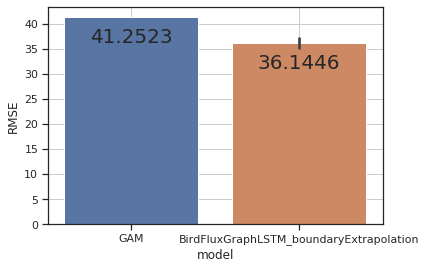

In [25]:
fig = utils.plot_average_errors(results_baseline, boundary=[], night_only=False, horizon=64, bird_thr=20)

1.953125e-07


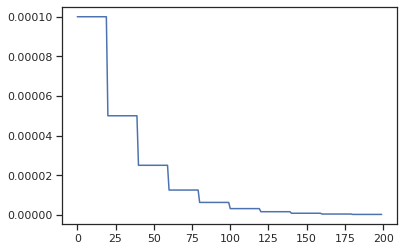

In [15]:
start = 1e-4
decay = 0.5
step = 20
lr = [start * decay**(i//step) for i in range(200)]
plt.plot(lr)
print(lr[-1])

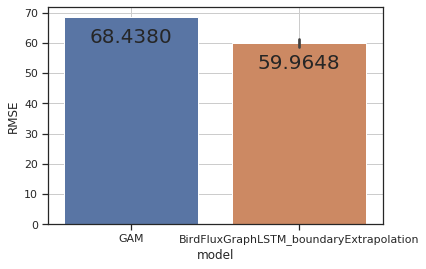

In [26]:
fig = utils.plot_average_errors(results_baseline, boundary=[], night_only=False, horizon=64, bird_thr=40)

In [28]:
5e-5 * np.sqrt(4)

0.0001

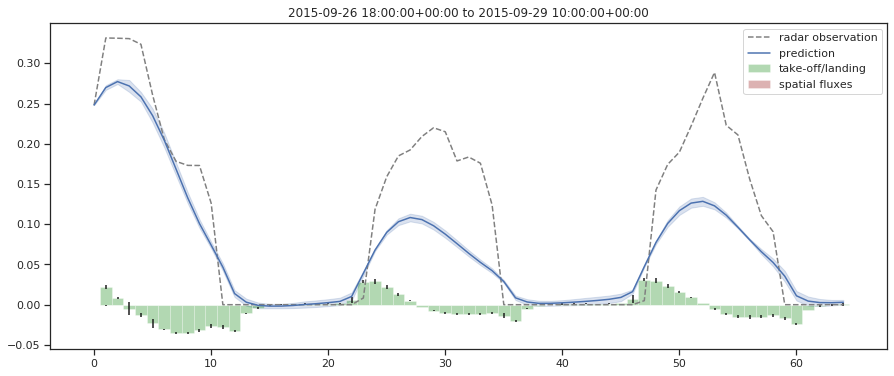

In [27]:
plot_example(results_baseline, bird_scales_baseline, 'BirdFluxGraphLSTM_boundaryExtrapolation', seqID=56, radar='defld', trial=None)

In [56]:
df = avg_classification_performance(results_baseline, thr=40, metric='sensitivity')
df

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

,model,sensitivity
0,GAM,0.005113


In [10]:
models = ['LocalLSTM',
    'BirdFluxGraphLSTM',
          'BirdFluxGraphLSTM_boundaryExtrapolation']
experiments = [#'array_job_7864944',
               'array_job_7884107',
    'array_job_7882608',
    'array_job_7882129']
results, bird_scales, fluxes, _, radar_idx = load_results_new(models, experiments, base_dir)#, ext='_no_nights')

/home/fiona/birdMigration/results/radar/training+testing/LocalLSTM/array_job_7884107
/home/fiona/birdMigration/results/radar/training+testing/BirdFluxGraphLSTM/array_job_7882608
5
/home/fiona/birdMigration/results/radar/training+testing/BirdFluxGraphLSTM_boundaryExtrapolation/array_job_7882129
5


### RMSE over all data points

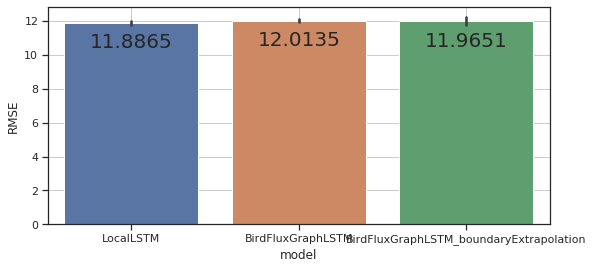

In [18]:
fig = utils.plot_average_errors(results, boundary=[], night_only=False, horizon=64)

### RMSE over data points with > 20 birds/km2

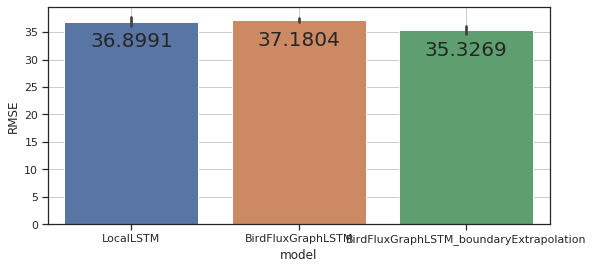

In [11]:
fig = utils.plot_average_errors(results, boundary=[], night_only=False, horizon=64, bird_thr=20)

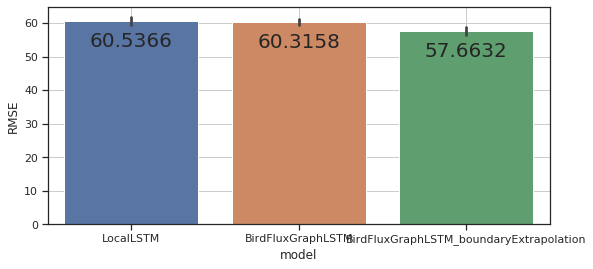

In [12]:
fig = utils.plot_average_errors(results, boundary=[], night_only=False, horizon=64, bird_thr=40)

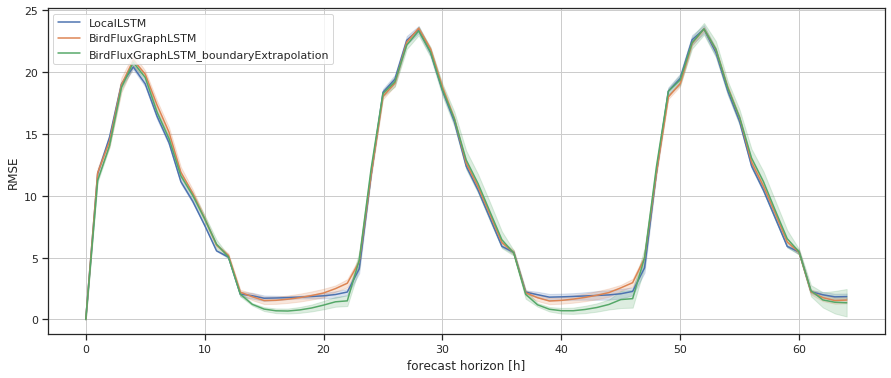

In [22]:
fig = utils.plot_errors(results)

In [16]:
df = avg_classification_performance(results, thr=20, metric='sensitivity')
df

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

,model,sensitivity
0,LocalLSTM,0.431439
1,BirdFluxGraphLSTM,0.496655
2,BirdFluxGraphLSTM_boundaryExtrapolation,0.611955


In [17]:
df = avg_classification_performance(results, thr=40, metric='sensitivity')
df

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

,model,sensitivity
0,LocalLSTM,0.123039
1,BirdFluxGraphLSTM,0.248855
2,BirdFluxGraphLSTM_boundaryExtrapolation,0.349732


/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

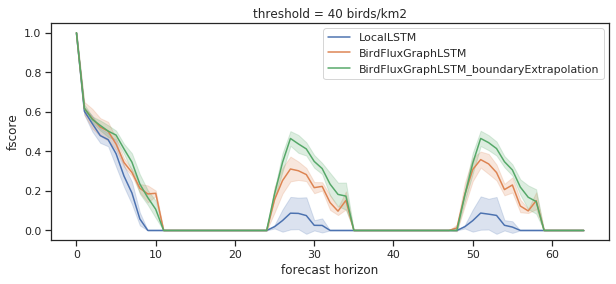

In [49]:
fig = plot_classification_performance(results, thr=40, metric='fscore')
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/fscore_model_comparison_thr40.png', bbox_inches='tight', dpi=300)

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

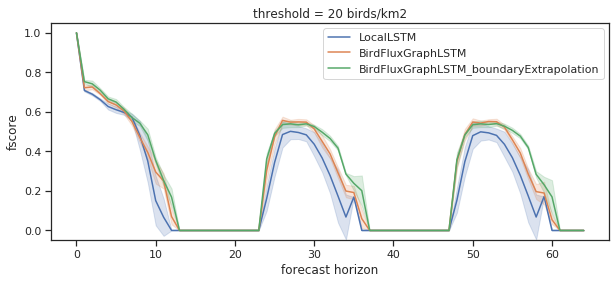

In [48]:
fig = plot_classification_performance(results, thr=20, metric='fscore')
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/fscore_model_comparison_thr20.png', bbox_inches='tight', dpi=300)

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

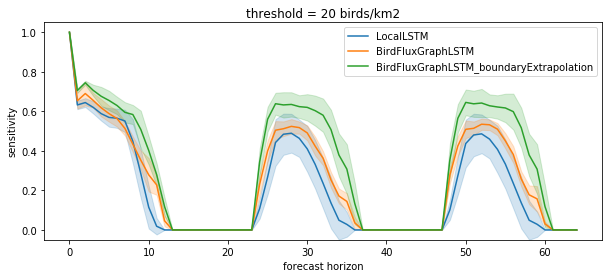

In [95]:
fig = plot_classification_performance(results, thr=20, metric='sensitivity')
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/sensitivity_model_comparison_thr20.png', bbox_inches='tight', dpi=300)

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

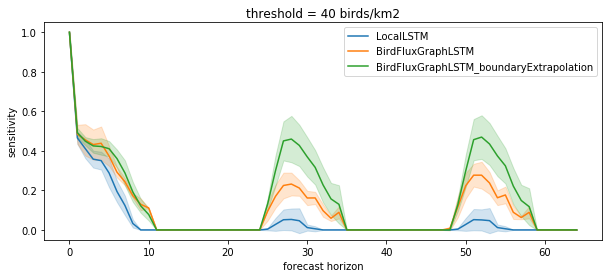

In [96]:
fig = plot_classification_performance(results, thr=40, metric='sensitivity')
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/sensitivity_model_comparison_thr40.png', bbox_inches='tight', dpi=300)

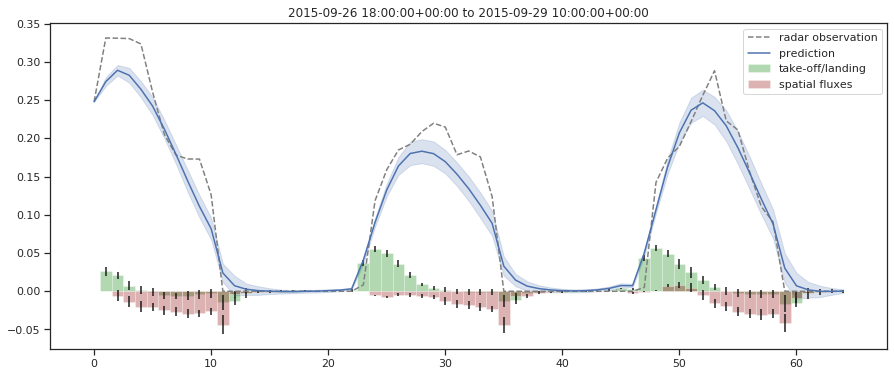

In [75]:
plot_example(results, bird_scales, 'BirdFluxGraphLSTM_boundaryExtrapolation', seqID=56, radar='defld', trial=None)

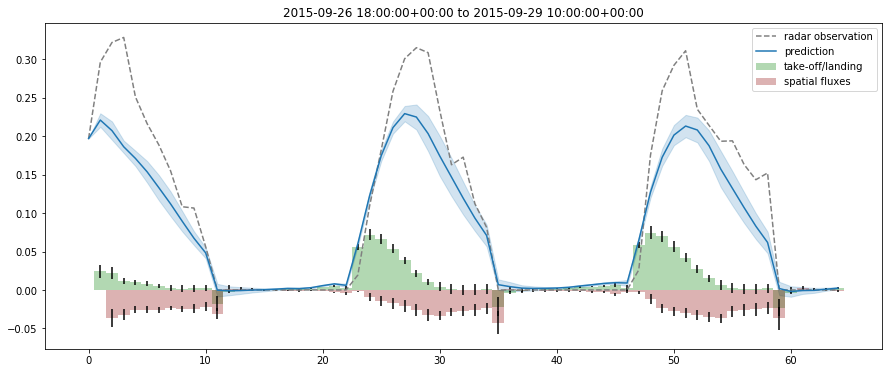

In [24]:
plot_example(results, bird_scales, 'BirdFluxGraphLSTM_boundaryExtrapolation', seqID=56, radar='depro', trial=None)

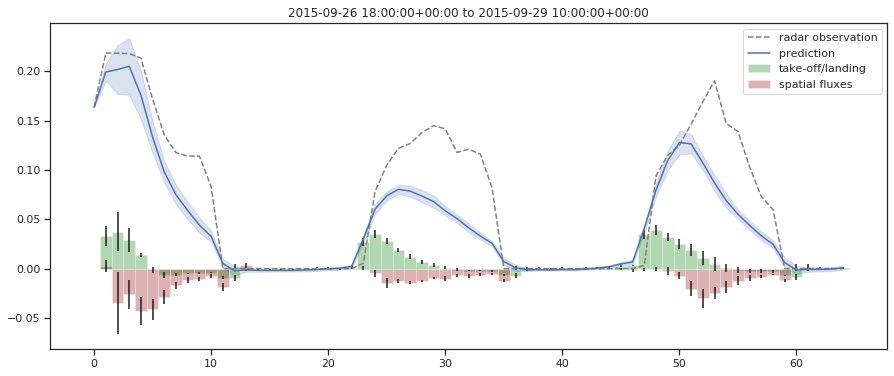

In [76]:
plot_example(results, bird_scales, 'BirdFluxGraphLSTM', seqID=56, radar='defld', trial=None)

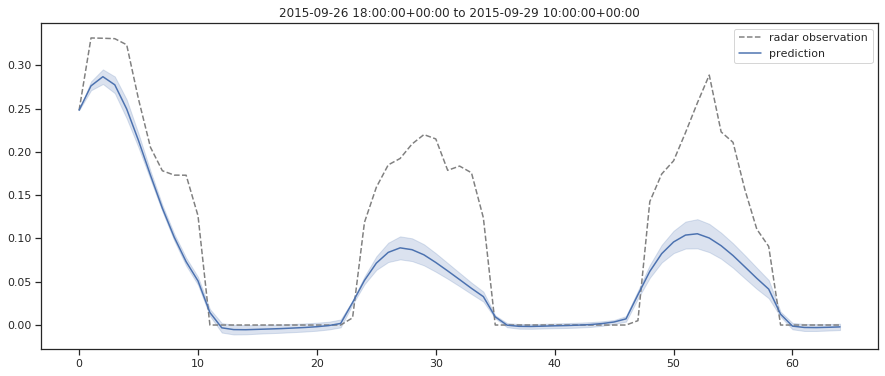

In [78]:
plot_example(results, bird_scales, 'LocalLSTM', seqID=56, radar='defld', trial=None)

In [25]:
def compute_rmse(residuals):
    mse = np.nanmean(np.square(residuals))
    rmse = np.sqrt(mse)
    return rmse

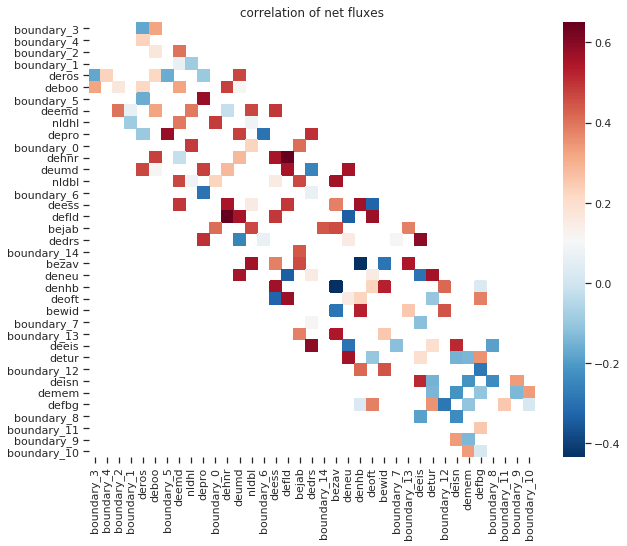

In [45]:
corr, angles, avg_rflux, avg_mflux = flux_corr_matrix(radar_idx[m], voronoi, G, results[m], fluxes[m][0], fluxes[m][1], best_trial, context=24, horizon=40)


[Text(0, 0.5, 'correlation coefficient'), Text(0.5, 0, 'avg abs model flux')]

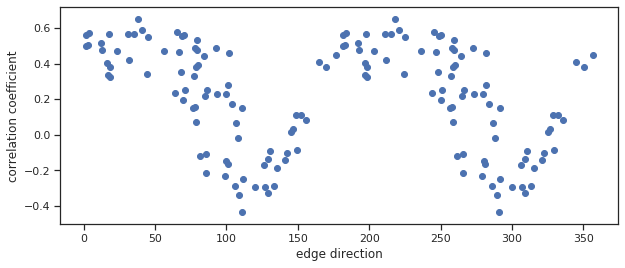

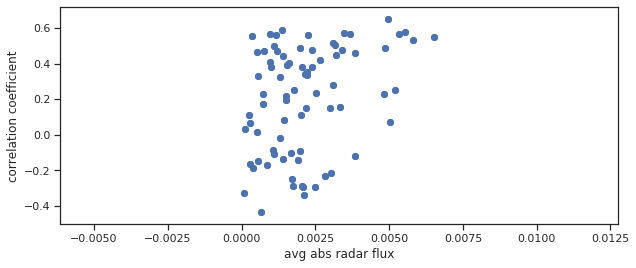

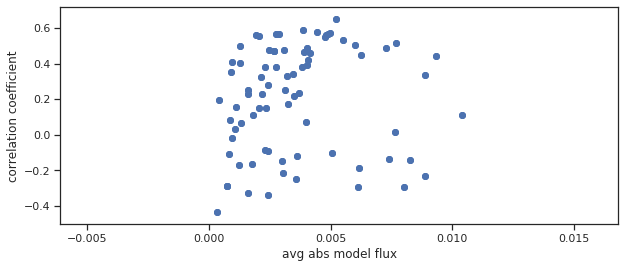

In [43]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(angles.flatten(), corr.flatten())
ax.set(xlabel='edge direction', ylabel='correlation coefficient')
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/corr_vs_edge_direction.png', bbox_inches='tight', dpi=300)

fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(avg_rflux.flatten(), corr.flatten())
ax.set(xlabel='avg abs radar flux', ylabel='correlation coefficient')

fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(avg_mflux.flatten(), corr.flatten())
ax.set(xlabel='avg abs model flux', ylabel='correlation coefficient')

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


4
true_pos = 0.29171223859605805, true_neg = 0.008886693980747732
['nldbl' 'dehnr' 'deneu' 'depro' 'bezav' 'defld' 'bejab' 'deros' 'deeis'
 'denhb' 'deess' 'dedrs' 'deoft' 'deboo' 'deemd' 'bewid' 'deisn' 'deumd'
 'defbg' 'demem' 'detur' 'nldhl' 'boundary_0' 'boundary_1' 'boundary_2'
 'boundary_3' 'boundary_4' 'boundary_5' 'boundary_6' 'boundary_7'
 'boundary_8' 'boundary_9' 'boundary_10' 'boundary_11' 'boundary_12'
 'boundary_13' 'boundary_14']
dict_values(['nldbl', 'dehnr', 'deneu', 'depro', 'bezav', 'defld', 'bejab', 'deros', 'deeis', 'denhb', 'deess', 'dedrs', 'deoft', 'deboo', 'deemd', 'bewid', 'deisn', 'deumd', 'defbg', 'demem', 'detur', 'nldhl', 'boundary_0', 'boundary_1', 'boundary_2', 'boundary_3', 'boundary_4', 'boundary_5', 'boundary_6', 'boundary_7', 'boundary_8', 'boundary_9', 'boundary_10', 'boundary_11', 'boundary_12', 'boundary_13', 'boundary_14'])
RMSE = -1.0057829769039017e-07


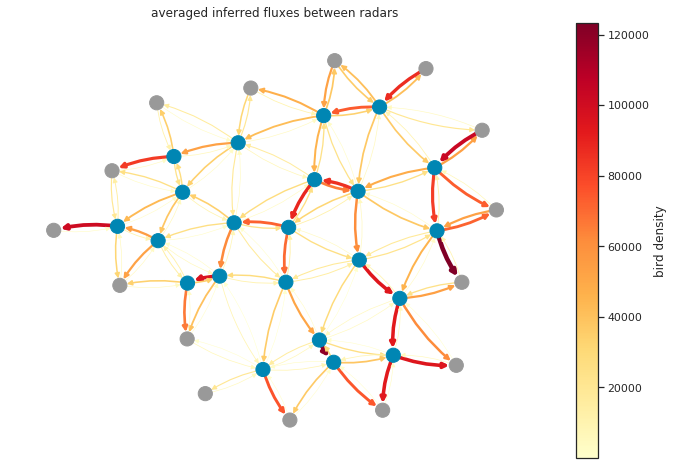

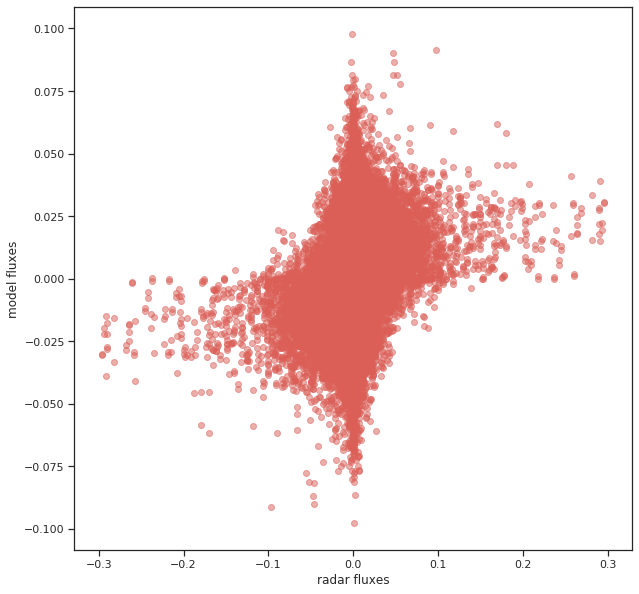

In [41]:
m = 'BirdFluxGraphLSTM_boundaryExtrapolation'
summary = results[m].groupby('trial').residual_km2.aggregate(compute_rmse)
best_trial = summary.argmax()
print(best_trial)
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_fluxes(voronoi, G, fluxes[m][0], results[m], trial=best_trial, encoder=1, context=0, horizon=64, bird_scale=bird_scales[m])
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/inferred_fluxes_BirdFluxGraphLSTM_boundaryExtrapolation.png', bbox_inches='tight', dpi=300)

fig = compare_fluxes_radar(voronoi, radar_idx[m], results, fluxes[m][0], fluxes[m][1], trial=best_trial, encoder=1, 
                           context=24, bird_scales=bird_scales, m=m, horizon=40)

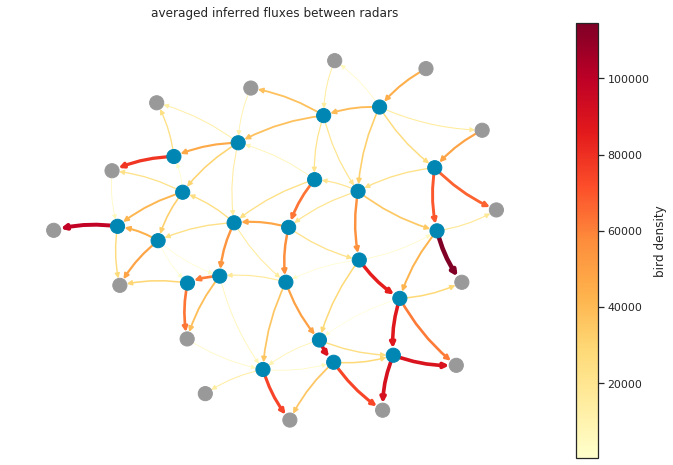

In [38]:
G_new, fig = plot_fluxes(voronoi, G, fluxes[m][0], results[m], trial=best_trial, encoder=1, context=0, horizon=64, bird_scale=bird_scales[m], net_fluxes=True)

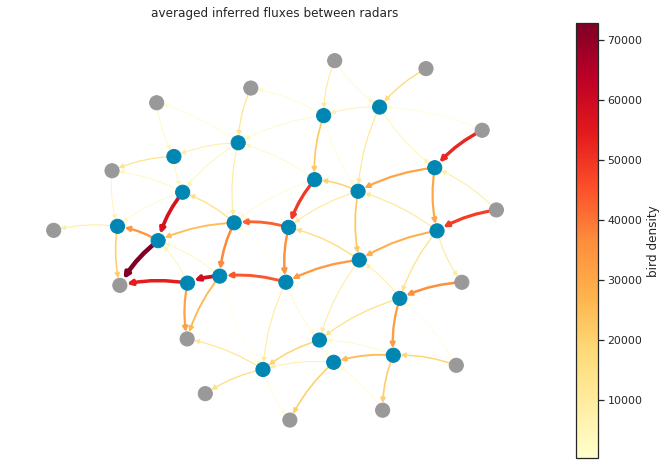

In [39]:
G_new, fig = plot_fluxes(voronoi, G, fluxes[m][1], results[m], trial=best_trial, encoder=1, context=24, horizon=64, bird_scale=bird_scales[m])

torch.Size([37, 37, 4017]) torch.Size([37, 37, 4017])
RMSE = -1.0057829769039017e-07


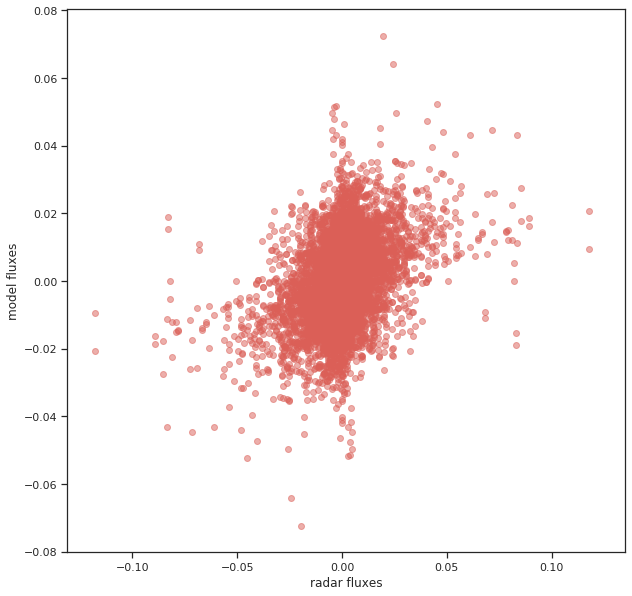

In [70]:
fig = compare_fluxes_radar(voronoi, G, results, fluxes[m][0], fluxes[m][1], trial=best_trial, encoder=1, 
                           context=24, bird_scales=bird_scales, m=m, horizon=40, radar='deumd')

torch.Size([22, 22, 4017]) torch.Size([22, 22, 4017])
RMSE = -1.2937289284309372e-07


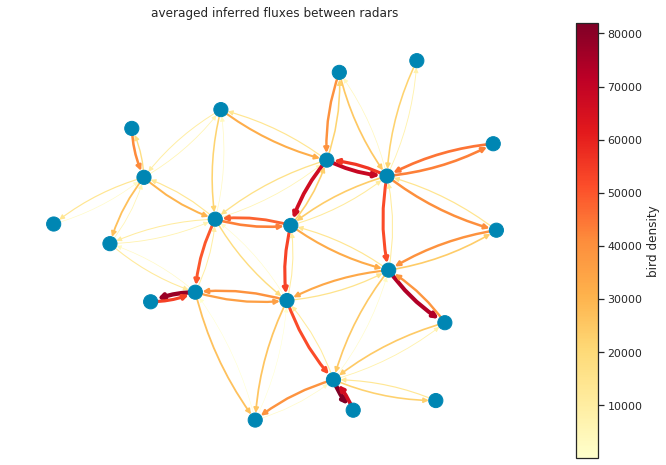

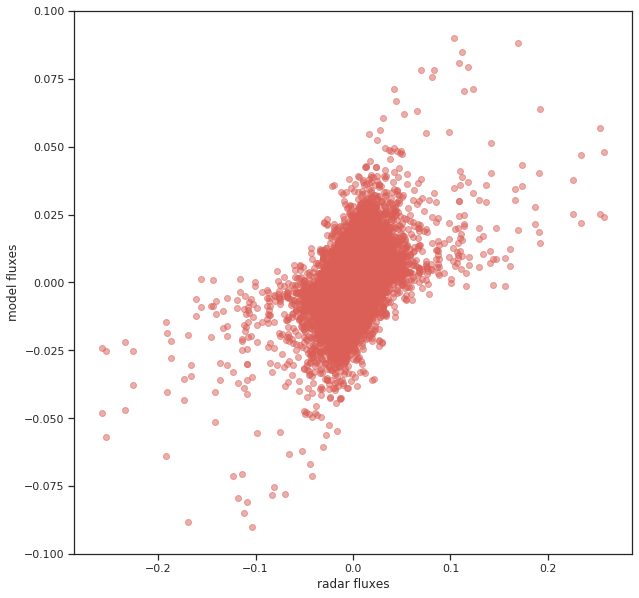

In [71]:
m = 'BirdFluxGraphLSTM'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)
trial = 4
G_new, fig = plot_fluxes(voronoi, G, fluxes[m][0], results[m], trial=trial, encoder=1, bird_scale=bird_scales[m])

fig = compare_fluxes_radar(voronoi, G, results, fluxes[m][0], fluxes[m][1], trial=trial, encoder=1, 
                           context=24, bird_scales=bird_scales, m=m, horizon=40)

In [14]:
# No encoder
models = ['LocalLSTM',
    'BirdFluxGraphLSTM',
    'BirdFluxGraphLSTM_boundaryExtrapolation']
experiments = ['array_job_7884133',
    'array_job_7864938',
    'array_job_7864931']
results_no_enc, bird_scales_no_enc, fluxes_no_enc, _, radar_idx_no_enc = load_results_new(models, experiments, base_dir)#, ext='_no_nights')

/home/fiona/birdMigration/results/radar/training+testing/LocalLSTM/array_job_7884133
/home/fiona/birdMigration/results/radar/training+testing/BirdFluxGraphLSTM/array_job_7864938
5
/home/fiona/birdMigration/results/radar/training+testing/BirdFluxGraphLSTM_boundaryExtrapolation/array_job_7864931
5


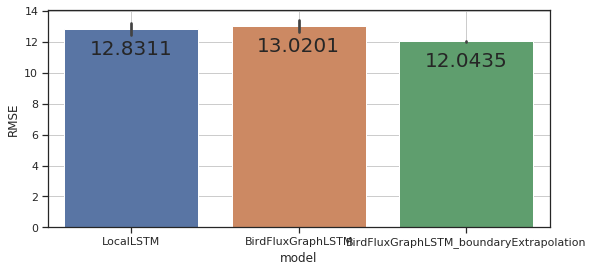

In [15]:
fig = utils.plot_average_errors(results_no_enc, boundary=[], night_only=False, horizon=64)

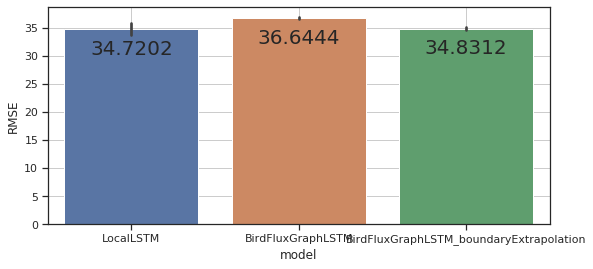

In [16]:
fig = utils.plot_average_errors(results_no_enc, boundary=[], night_only=False, horizon=64, bird_thr=20)

In [ ]:
fig = utils.plot_average_errors(results_no_enc, boundary=[], night_only=False, horizon=64, bird_thr=40)

In [ ]:
df = avg_classification_performance(results_no_enc, thr=20, metric='sensitivity')
df

In [ ]:
df = avg_classification_performance(results_no_enc, thr=40, metric='sensitivity')
df

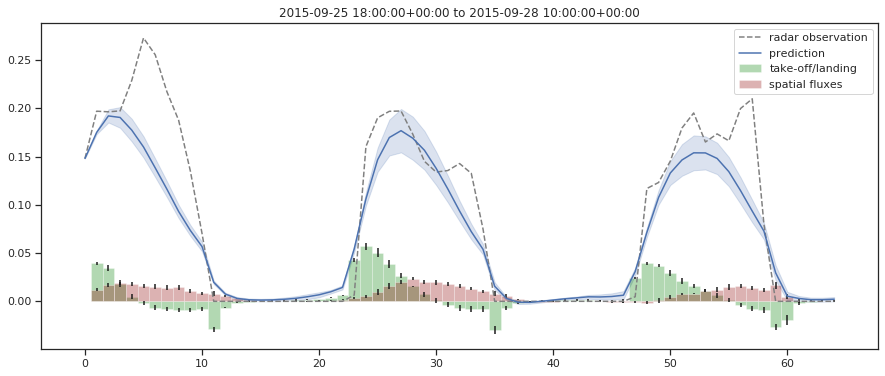

In [37]:
plot_example(results_no_enc, bird_scales_no_enc, 'BirdFluxGraphLSTM_boundaryExtrapolation', seqID=55, radar='dehnr', trial=None)

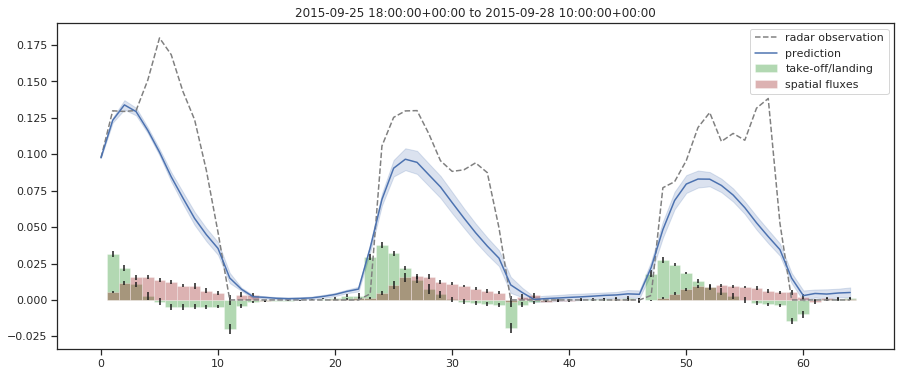

In [38]:
plot_example(results_no_enc, bird_scales_no_enc, 'BirdFluxGraphLSTM', seqID=55, radar='dehnr', trial=None)

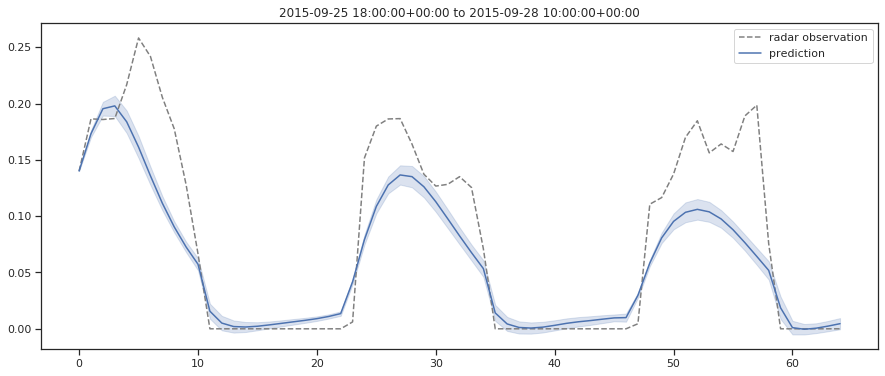

In [60]:
plot_example(results_no_enc, bird_scales_no_enc, 'LocalLSTM', seqID=55, radar='dehnr', trial=None)

In [57]:
G.get_edge_data(0, 4)['angle']

211.16165608861198

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


4
['nldbl' 'dehnr' 'deneu' 'depro' 'bezav' 'defld' 'bejab' 'deros' 'deeis'
 'denhb' 'deess' 'dedrs' 'deoft' 'deboo' 'deemd' 'bewid' 'deisn' 'deumd'
 'defbg' 'demem' 'detur' 'nldhl' 'boundary_0' 'boundary_1' 'boundary_2'
 'boundary_3' 'boundary_4' 'boundary_5' 'boundary_6' 'boundary_7'
 'boundary_8' 'boundary_9' 'boundary_10' 'boundary_11' 'boundary_12'
 'boundary_13' 'boundary_14'] 0           nldbl
1           dehnr
2           deneu
3           depro
4           bezav
5           defld
6           bejab
7           deros
8           deeis
9           denhb
10          deess
11          dedrs
12          deoft
13          deboo
14          deemd
15          bewid
16          deisn
17          deumd
18          defbg
19          demem
20          detur
21          nldhl
22     boundary_0
23     boundary_1
24     boundary_2
25     boundary_3
26     boundary_4
27     boundary_5
28     boundary_6
29     boundary_7
30     boundary_8
31     boundary_9
32    boundary_10
33    boundary_11
34 

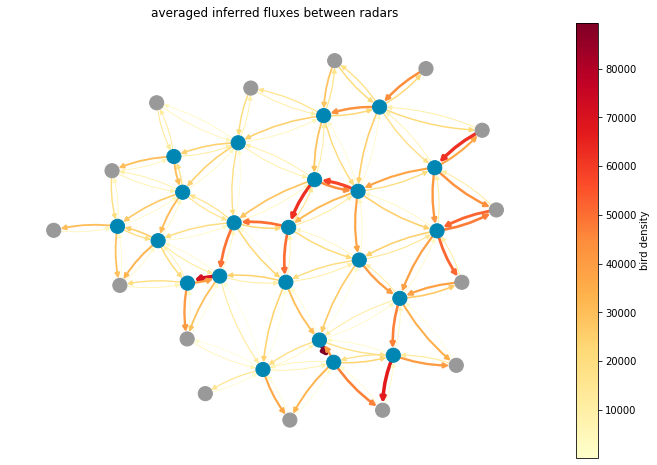

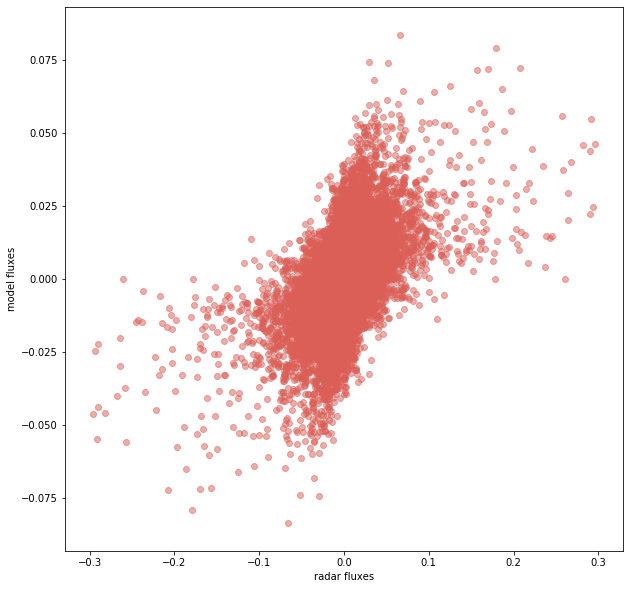

In [59]:
m = 'BirdFluxGraphLSTM_boundaryExtrapolation'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)
summary = results[m].groupby('trial').residual_km2.aggregate(compute_rmse)
best_trial = summary.argmax()
print(best_trial)
G_new, fig = plot_fluxes(voronoi, G, fluxes_no_enc[m][0], results_no_enc[m], trial=best_trial, encoder=0, bird_scale=bird_scales_no_enc[m])

fig = compare_fluxes_radar(voronoi, radar_idx_no_enc[m], results_no_enc, fluxes_no_enc[m][0], fluxes_no_enc[m][1], trial=best_trial, encoder=0, 
                           context=0, bird_scales=bird_scales_no_enc, m=m, horizon=12)

torch.Size([37, 37, 4017]) torch.Size([37, 37, 4017])
RMSE = -1.0057829769039017e-07


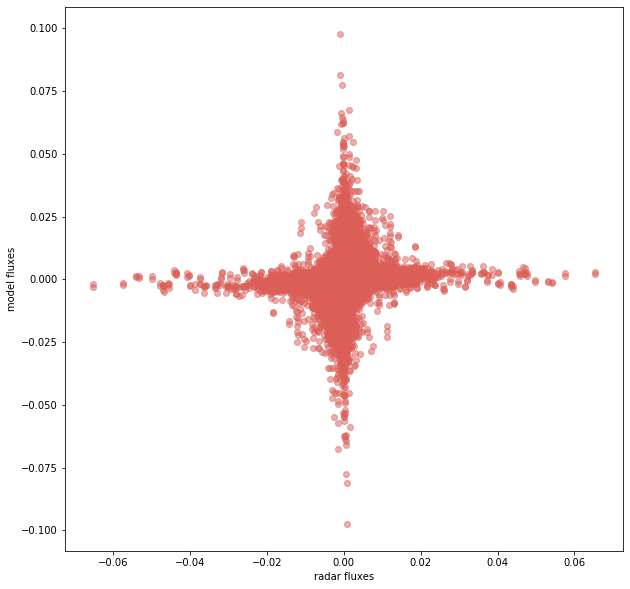

In [16]:
fig = compare_fluxes_radar(voronoi, G, results, fluxes[m][0], fluxes[m][1], trial=best_trial, encoder=1, 
                           context=24, bird_scales=bird_scales, m=m, horizon=40, radar='defbg')

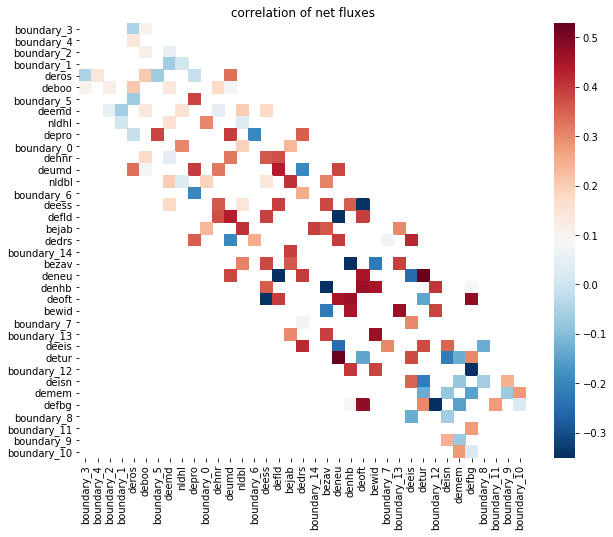

In [77]:
corr, angles, avg_flux = flux_corr_matrix(radar_idx_no_enc[m], voronoi, G, results_no_enc[m], fluxes_no_enc[m][0], fluxes_no_enc[m][1], best_trial, context=24, horizon=40)

[Text(0, 0.5, 'correlation coefficient'), Text(0.5, 0, 'edge direction')]

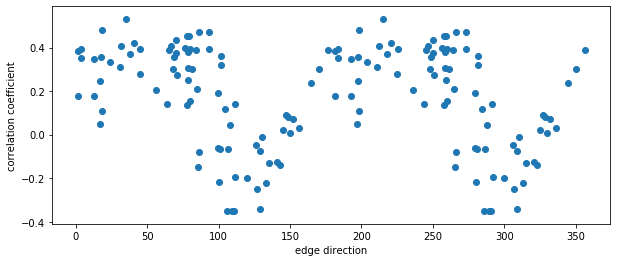

In [78]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(angles.flatten(), corr.flatten())
ax.set(xlabel='edge direction', ylabel='correlation coefficient')

[Text(0, 0.5, 'correlation coefficient'), Text(0.5, 0, 'avg abs radar flux')]

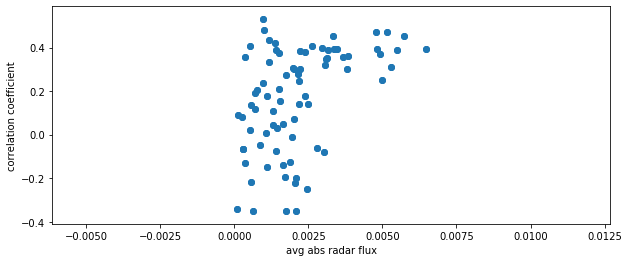

In [79]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(avg_flux.flatten(), corr.flatten())
ax.set(xlabel='avg abs radar flux', ylabel='correlation coefficient')